# Pubmed sequential sentence classification

* Research Paper - https://arxiv.org/abs/1710.06071

## Goal - (255 - 256)

* Download a text dataset (PubMed 200K RCT)
* Write a preprocessing function for our test data
* One Hot Encoding & Label Encoding.
* Setting up multiple modelling experiments with different levels of embedding
* Building a **multimodal model** to take in different sources of data
  * Replicating the model discussed in this paper (https://arxiv.org/abs/1710.06071)
  * Actual model description (https://arxiv.org/abs/1612.05251)
* Finding the most wrong predictions
* Reference Model

![Reference Model](https://raw.githubusercontent.com/rkumar-bengaluru/data-science/main/20-Tensorflow/07-Skimlit/model.jpg)

## SkimLit Inputs and Outputs (257) - Ignore

## Get the data (258 - 259)

Download the dataset for pubmed 200K RCT from https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

/bin/bash: /home/rupak/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [2]:
!dir pubmed-rct

/bin/bash: /home/rupak/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
import os

# root data directory
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
# list of file names
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
print(filenames)

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt', 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt', 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']


### Preprocess Data (260)

Write a function which will read each line of the file and create the below structure:

```
[{ 'line_number' : 0,
   'target'  : 'first few characters till \t tab character',
   'text'   : 'full text after \t character till end of line character \n',
   'total_lines' : 
 },
 ...
]
```

Ignore line starting with ### and repeat the same for train_data, validation_data and test_data

In [4]:
import os

def get_lines(file_name):
    """
    Reads the file_name and returns the content of the file as list
    """
    with open(file_name) as f:
        lines = f.readlines()
    return lines

validation_lines = get_lines(filenames[0])
test_lines = get_lines(filenames[1])
train_lines = get_lines(filenames[2])

print(f"size of train lines is {len(train_lines)}")
print(f"size of validation lines is {len(validation_lines)}")
print(f"size of test lines is {len(test_lines)}")

def create_data_set(lines):
    data = []
    items = []
    index = 0
    for line in lines:
        
        if line.startswith('\n'):
            for item in items:
                item['total_lines'] = index -1
                data.append(item)
            index = 0
            items = []
        else:
            tokens = line.split('\t')
        
            if len(tokens) > 1:
                item = {'line_number':index,'target': tokens[0],'text':tokens[1].strip() ,'total_lines' :index}
                items.append(item)
                index = index + 1
    return data

train_data = create_data_set(train_lines)
validation_data = create_data_set(validation_lines)
test_data = create_data_set(test_lines)

print(f"size of train data is {len(train_data)}")
print(f"size of validation data is {len(validation_data)}")
print(f"size of test data is {len(test_data)}")


size of train lines is 210040
size of validation lines is 35212
size of test lines is 35135
size of train data is 180040
size of validation data is 30212
size of test data is 30135


### Visualize Data (261)

Use pandas dataframe

head of train data
   line_number     target                                               text  \
0            0  OBJECTIVE  To investigate the efficacy of @ weeks of dail...   
1            1    METHODS  A total of @ patients with primary knee OA wer...   
2            2    METHODS  Outcome measures included pain reduction and i...   
3            3    METHODS  Pain was assessed using the visual analog pain...   
4            4    METHODS  Secondary outcome measures included the Wester...   

   total_lines  
0           11  
1           11  
2           11  
3           11  
4           11  
unique counts of each target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64


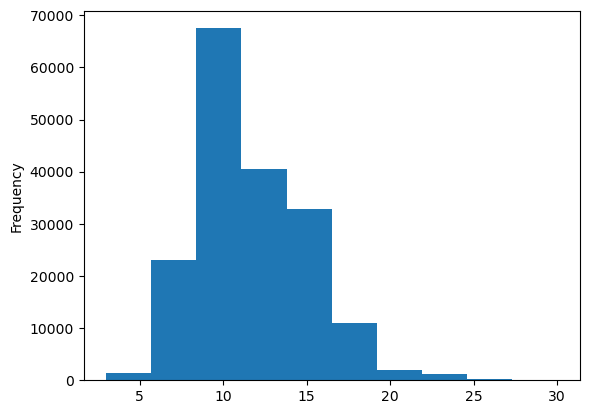

In [5]:
# Visualize data with data frame.

import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.DataFrame(train_data)
val_df   = pd.DataFrame(validation_data)
test_df  = pd.DataFrame(test_data)
# print the head
print('head of train data')
print(train_df.head())
print('unique counts of each target')
print(train_df['target'].value_counts())
# length of different lines
train_df.total_lines.plot.hist();


In [6]:
# convert to list
train_sentences = train_df['text'].tolist()
val_sentences   = val_df['text'].tolist()
test_sentences  = test_df['text'].tolist()
print(f"train sentences length {len(train_sentences)}")
print(f"val sentences length {len(val_sentences)}")
print(f"test sentences length {len(test_sentences)}")

train sentences length 180040
val sentences length 30212
test sentences length 30135


## One Hot Encoding & Label Encoding (262)

In [7]:
import sklearn
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import tensorflow as tf

#tf.debugging.set_log_device_placement(True)

onehot = OneHotEncoder(sparse_output=False)
train_label_one_hot = tf.constant(onehot.fit_transform(train_df['target'].to_numpy().reshape(-1,1)))
val_label_one_hot    = tf.constant(onehot.transform(val_df['target'].to_numpy().reshape(-1,1)))
test_label_one_hot   = tf.constant(onehot.transform(test_df['target'].to_numpy().reshape(-1,1)))
print('one hot encoding')
print(train_label_one_hot[0],val_label_one_hot[0],test_label_one_hot[0])

# label encoder
labelencode = LabelEncoder()
train_label_encoded = labelencode.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_label_encoded = labelencode.transform(val_df['target'].to_numpy().reshape(-1,1))
test_label_encoded = labelencode.transform(test_df['target'].to_numpy().reshape(-1,1))
print('label encoding...')
print(train_label_encoded[0],val_label_encoded[0],test_label_encoded[0])

print('classnames')
classnames = labelencode.classes_
print('class name = ', classnames, 'length of classes =', len(classnames))

2023-05-25 08:34:02.838023: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


one hot encoding
tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float64) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float64) tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float64)
label encoding...
3 0 0
classnames
class name =  ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS'] length of classes = 5


2023-05-25 08:34:06.494706: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/home/rupak/miniconda3/envs/tf_hub/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rupak/miniconda3/envs/tf_hub/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


## Experiments to be Conducted (262)

![Experiments](https://raw.githubusercontent.com/rkumar-bengaluru/data-science/main/20-Tensorflow/07-Skimlit/resources/experiments.jpg)

## Model 0 - Naive Bayes with TF-IDF Encoder (263)

* Selection Method
![Machine Learning Map](https://raw.githubusercontent.com/rkumar-bengaluru/data-science/main/20-Tensorflow/07-Skimlit/resources/ml_map.png)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

def find_scores(val_label_encoded,val_preds):
    a_score = accuracy_score(y_true=val_label_encoded,y_pred=val_preds)
    p_score = precision_score(y_true=val_label_encoded,y_pred=val_preds,average='weighted')
    r_score = recall_score(y_true=val_label_encoded,y_pred=val_preds,average='weighted')
    f_score = f1_score(y_true=val_label_encoded,y_pred=val_preds,average='weighted')
    return {'accuracy_score' : a_score, 
            'precision_score' : p_score, 
            'recall_score' : r_score,
            'f1_score' : f_score}

model_0 = Pipeline([('tf-idf',TfidfVectorizer()),
               ('naive_bayes',MultinomialNB())])
model_0.fit(X=train_sentences,y=train_label_encoded)

y_pred = model_0.score(X=val_sentences,y=val_label_encoded)

val_preds = model_0.predict(val_sentences)
model_0_results = find_scores(val_label_encoded,val_preds)
print(model_0_results)

{'accuracy_score': 0.7218323844829869, 'precision_score': 0.7186466952323352, 'recall_score': 0.7218323844829869, 'f1_score': 0.6989250353450294}


## Model 1 - Conv1D with token Embedding 

### Data Visualization (264)

mean tokens in each sentences  26.338269273494777
no of tokens to keep to cover 95% of the sentence tokens in training data is 55


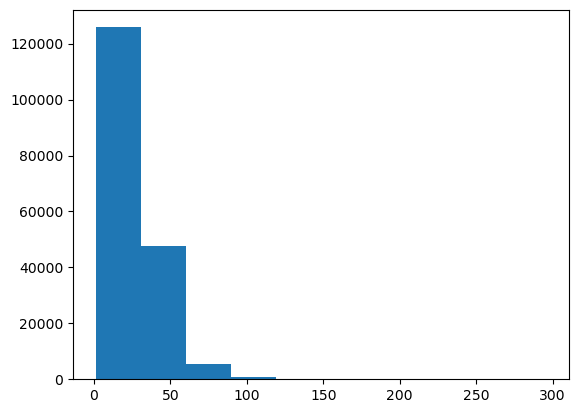

In [9]:
import numpy as np
import matplotlib.pyplot as plt
# find how tokens is each sentences
lengths = [len(sen.split()) for sen in train_sentences]
print('mean tokens in each sentences ', np.mean(lengths))
output_sequence_length = int(np.percentile(lengths,95))
# find percentile to cover 95% of the sentence tokens
print(f"no of tokens to keep to cover 95% of the sentence tokens in training data is {output_sequence_length}")
plt.hist(lengths,bins=10);

### Vectorize Tokens (265)

In [10]:
# create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens = 68000
text_vectorization = TextVectorization(max_tokens=max_tokens,
                                      output_sequence_length=output_sequence_length)

text_vectorization.adapt(train_sentences)

# check the output of text vectorization
import random
sample_sentence = random.choice(train_sentences)
print(f"Sample Sentence Text \n {sample_sentence}\n")
print(f"length of the Sample Sentence {len(sample_sentence)}")
print(f"Vectorized Sample Sentence\n {text_vectorization([sample_sentence])}")

# how many words in our vocabulary
rct_20k_text_vocab = text_vectorization.get_vocabulary()
print(f"total no of words in the vocabulary is {len(rct_20k_text_vocab)}")
print(f"most common words in the vocabulary is \n {rct_20k_text_vocab[:10]}")
print(f"least common words in the vocabulary is \n {rct_20k_text_vocab[-10:]}")

# print text vectorization config
t_config = text_vectorization.get_config()
print(t_config)

Sample Sentence Text 
 Among infants born prematurely , competence at oral feeding is necessary for growth and hospital discharge .

length of the Sample Sentence 108
Vectorized Sample Sentence
 [[ 116  337 2888 5116 4391   15  217 1310   20 1537   11  621    3  237
   696    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
total no of words in the vocabulary is 64841
most common words in the vocabulary is 
 ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']
least common words in the vocabulary is 
 ['aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']
{'name': 'text_vectorization', 'trainable': True, 'dtype': 'string', 'batch_input_shape': (None,), 'max_tokens': 68000, 'standardize': 'lower_and_strip_punctuation', 'split': 'whitespace', 'ngrams': None, 'output_mode': 'int',

### Token Embedding (266)

In [11]:
# add a embedding layer
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(input_dim=len(rct_20k_text_vocab),
                 output_dim=128,
                  mask_zero=True,
                  name='token_embedding')
# token embedding
print(f"Sentence before embedding \n {sample_sentence}")
vectorized_sentence = text_vectorization([sample_sentence])
print(f"vectorized sentence \n {vectorized_sentence}")
embed_sentence = embedding_layer(vectorized_sentence)
print(f"embedded sentence \n {embed_sentence}")
print(f"embedded sentence shape \n {embed_sentence.shape}")

Sentence before embedding 
 Among infants born prematurely , competence at oral feeding is necessary for growth and hospital discharge .
vectorized sentence 
 [[ 116  337 2888 5116 4391   15  217 1310   20 1537   11  621    3  237
   696    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]
embedded sentence 
 [[[ 0.01277343  0.00230336 -0.00389149 ...  0.04547533 -0.02926291
   -0.02436393]
  [ 0.04531531 -0.02648103  0.04667736 ...  0.02195307  0.00172501
   -0.00336784]
  [-0.01192015  0.01623799 -0.03544437 ...  0.03967075 -0.04762563
    0.01072605]
  ...
  [-0.00649441 -0.02365108 -0.01761366 ... -0.00798734  0.02565967
    0.01511272]
  [-0.00649441 -0.02365108 -0.01761366 ... -0.00798734  0.02565967
    0.01511272]
  [-0.00649441 -0.02365108 -0.01761366 ... -0.00798734  0.02565967
    0.01511272]]]
embedded sentence shape 
 (1, 

## Create Dataset using tf.data.Dataset (267)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_label_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_label_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_label_one_hot))

# for fast performance 
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset   = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Build Conv1D model (268)

In [14]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Input, TextVectorization, Embedding,Dense

# input layer
inputs = Input(shape=(1,),dtype=tf.string,name="input")
# text vectorization layer
max_tokens = 68000
lengths = [len(sen.split()) for sen in train_sentences]
output_sequence_length = int(np.percentile(lengths,95))
text_vectorizer = TextVectorization(max_tokens=max_tokens, 
                      output_sequence_length=output_sequence_length,
                                   name="vectorization_layer")
text_vectorizer.adapt(train_sentences)
vectors = text_vectorizer(inputs)
# embedding layer
embedding = Embedding(input_dim=len(rct_20k_text_vocab),
                     output_dim=128,
                     mask_zero=True,
                      name="token_embedding_layer")
token_embedding = embedding(vectors)
# conv1d layer
x = Conv1D(filters=64,
          kernel_size=5,
          padding="same",
          activation="relu",
          name="conv1d_Layer")(token_embedding)
# average pooling
x = GlobalAveragePooling1D(name="global_average_pooling")(x)
# output layer
outputs = Dense(5,activation="softmax", name="fully_connected")(x)
# finally the model
model_1 = Model(inputs,outputs)

# compile the model
model_1.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
# summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1)]               0         
                                                                 
 vectorization_layer (TextVe  (None, 55)               0         
 ctorization)                                                    
                                                                 
 token_embedding_layer (Embe  (None, 55, 128)          8299648   
 dding)                                                          
                                                                 
 conv1d_Layer (Conv1D)       (None, 55, 64)            41024     
                                                                 
 global_average_pooling (Glo  (None, 64)               0         
 balAveragePooling1D)                                            
                                                             

In [31]:
import time

def fit_the_model(model):
    
    # fit the model
    start_time = time.time()
    history = model.fit(train_dataset,
                             steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                             validation_data=val_dataset,
                             validation_steps=int(0.1*len(val_dataset)))
    time_taken = time.time() - start_time
    print(f"time taken to fit {time_taken}")
    return history

In [16]:
# let's try with cpu
#with tf.device("/cpu:0"):
#    fit_the_model(model_1)

In [17]:
# with gpu
with tf.device("/gpu:0"):
    fit_the_model(model_1)

Epoch 1/3


2023-05-25 08:34:37.145613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [180040,5]
	 [[{{node Placeholder/_1}}]]


562/562 [==============================] - ETA: 0s - loss: 0.9216 - accuracy: 0.6334

2023-05-25 08:35:17.542521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [30212,5]
	 [[{{node Placeholder/_1}}]]


562/562 [==============================] - 41s 71ms/step - loss: 0.9216 - accuracy: 0.6334 - val_loss: 0.6882 - val_accuracy: 0.7394
Epoch 2/3
562/562 [==============================] - 36s 64ms/step - loss: 0.6592 - accuracy: 0.7563 - val_loss: 0.6319 - val_accuracy: 0.7699
Epoch 3/3
562/562 [==============================] - 35s 62ms/step - loss: 0.6198 - accuracy: 0.7767 - val_loss: 0.5977 - val_accuracy: 0.7826
time taken to fit 111.93111944198608


In [18]:
# evalue the model
model_1.evaluate(val_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.6015 - accuracy: 0.7839


[0.6015175580978394, 0.7838938236236572]

In [19]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs,model_1_pred_probs.shape

945/945 [==============================] - 4s 4ms/step


(array([[4.2633256e-01, 1.8590795e-01, 9.9755667e-02, 2.6384270e-01,
         2.4161216e-02],
        [4.5196444e-01, 2.5112864e-01, 1.1524048e-02, 2.7793929e-01,
         7.4436255e-03],
        [1.2931105e-01, 1.0147102e-02, 1.3950986e-03, 8.5909355e-01,
         5.3225856e-05],
        ...,
        [2.3192902e-06, 1.0413789e-03, 4.7144821e-04, 1.5524093e-06,
         9.9848336e-01],
        [5.9557542e-02, 3.9768589e-01, 1.3298537e-01, 8.2954682e-02,
         3.2681653e-01],
        [1.9893937e-01, 6.6024572e-01, 3.4642261e-02, 3.4235310e-02,
         7.1937367e-02]], dtype=float32),
 (30212, 5))

In [20]:
model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [21]:
model_1_results = find_scores(val_label_encoded,model_1_preds)
model_0_results,model_1_results,

({'accuracy_score': 0.7218323844829869,
  'precision_score': 0.7186466952323352,
  'recall_score': 0.7218323844829869,
  'f1_score': 0.6989250353450294},
 {'accuracy_score': 0.7838938170263472,
  'precision_score': 0.7804753176617882,
  'recall_score': 0.7838938170263472,
  'f1_score': 0.7814327373922647})

## Model 2 Architecture - Tensorflow Hub Pretrained Feature Extractor (269 - 270)
![Model 2 Architecture](https://raw.githubusercontent.com/rkumar-bengaluru/data-science/main/20-Tensorflow/07-Skimlit/resources/model_2_architecture.jpg)

In [26]:
import tensorflow_hub as hub
import random
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense

with tf.device('/cpu:0'):
    use = 'https://tfhub.dev/google/universal-sentence-encoder/4'
    universal_sentence_encoder = hub.KerasLayer(use,
                              trainable=False,
                              name='universal_encoder_layer')

In [27]:
random_sentence = random.choice(train_sentences)
print(f"random sentence to encode with hub encoder \n {random_sentence}")
random_sentence_encoded = universal_sentence_encoder([random_sentence])
print(f"shape of encoded sentence {random_sentence_encoded.shape}")
print(f"encoded sentence \n {random_sentence_encoded}")

random sentence to encode with hub encoder 
 To study the synergistic effects of electroacupuncture on the treatment of knee osteoarthritis after arthroscopic debridement .


2023-05-25 08:47:46.118992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


shape of encoded sentence (1, 512)
encoded sentence 
 [[ 0.06279134  0.01369973  0.06582981 -0.07669555 -0.04587398 -0.0082109
  -0.00636394 -0.05387252 -0.03135108  0.05190504  0.07005625 -0.02295379
  -0.03951597  0.02275148 -0.01565056 -0.01587343 -0.09541735 -0.0490605
   0.04042636 -0.08189386 -0.08149713  0.00934574 -0.0189915  -0.02616037
  -0.00304986 -0.03329622  0.00513394 -0.01424686 -0.02965057  0.0427039
  -0.07556157  0.09493107  0.04094959  0.05921735 -0.04571599  0.03442181
   0.04333055 -0.01924521 -0.03956519 -0.06948345 -0.06448104  0.00067883
   0.01696799 -0.04504972  0.06839738  0.06816462 -0.02787285 -0.03543166
  -0.03453318 -0.01731843 -0.05757599  0.06948152  0.01670033  0.04007629
   0.04789853 -0.07235609 -0.02558368  0.02350361  0.04136902  0.00662814
  -0.04349505  0.05234401  0.01109951  0.00971564  0.01426537  0.01072548
  -0.00139672  0.00118097 -0.05357008 -0.03579675  0.01774899  0.02621061
  -0.02951406 -0.06358261 -0.01070951  0.03920368 -0.04648815

In [30]:
# create model 2
inputs = Input(shape=[],dtype=tf.string,name='input_layer')
pretrained_embedding = universal_sentence_encoder(inputs)
dense = Dense(128,activation='relu',name='fully_connected_layer')(pretrained_embedding)
outputs = Dense(5,activation='softmax',name='output_layer')(dense)
model_2 = Model(inputs=inputs,
               outputs=outputs,
               name='model_2_use_feature_extractor')
model_2.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])
model_2.summary()

Model: "model_2_use_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_encoder_layer (Ke  (None, 512)              256797824 
 rasLayer)                                                       
                                                                 
 fully_connected_layer (Dens  (None, 128)              65664     
 e)                                                              
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


2023-05-25 08:48:30.790703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder' with dtype string and shape [?]
	 [[{{node Placeholder}}]]


In [32]:
model_2_history = fit_the_model(model_2)

Epoch 1/3


2023-05-25 08:50:05.146891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,512]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-05-25 08:50:05.147090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1' with dtype float and shape [?,1]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1}}]]
2023-05-25 08:50:05.147187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor s

2023-05-25 08:50:05.527497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall' with dtype float and shape [?,512]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall}}]]
2023-05-25 08:50:05.527714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1' with dtype float and shape [?,1]
	 [[{{node gradients/StatefulPartitionedCall_grad/StatefulPartitionedCall_1}}]]
2023-05-25 08:50:05.527826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor s

562/562 [==============================] - 14s 18ms/step - loss: 0.9138 - accuracy: 0.6519 - val_loss: 0.7964 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 10s 17ms/step - loss: 0.7698 - accuracy: 0.7001 - val_loss: 0.7566 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7543 - accuracy: 0.7106 - val_loss: 0.7408 - val_accuracy: 0.7091
time taken to fit 32.36796450614929


In [35]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.7433 - accuracy: 0.7122


[0.7433463931083679, 0.7121673226356506]

In [36]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 12s 12ms/step


array([[4.4944400e-01, 3.5606056e-01, 2.4508263e-03, 1.8513425e-01,
        6.9103125e-03],
       [3.7590060e-01, 4.6711719e-01, 3.3676501e-03, 1.5109076e-01,
        2.5238886e-03],
       [2.2161715e-01, 1.3517791e-01, 2.0782413e-02, 5.8665496e-01,
        3.5767544e-02],
       ...,
       [1.3876472e-03, 6.7633619e-03, 6.3646480e-02, 8.7879790e-04,
        9.2732370e-01],
       [4.1676322e-03, 4.2155392e-02, 1.8219441e-01, 1.4202939e-03,
        7.7006227e-01],
       [1.7574263e-01, 2.6174513e-01, 4.9640658e-01, 6.7782914e-03,
        5.9327383e-02]], dtype=float32)

In [37]:
model_2_pred = tf.argmax(model_2_pred_probs,axis=1)
model_2_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [38]:
model_2_results = find_scores(val_label_encoded,model_2_pred)

In [40]:
model_2_results,model_1_results,model_0_results

({'accuracy_score': 0.7121673507215676,
  'precision_score': 0.7125300719774355,
  'recall_score': 0.7121673507215676,
  'f1_score': 0.7092435683039221},
 {'accuracy_score': 0.7838938170263472,
  'precision_score': 0.7804753176617882,
  'recall_score': 0.7838938170263472,
  'f1_score': 0.7814327373922647},
 {'accuracy_score': 0.7218323844829869,
  'precision_score': 0.7186466952323352,
  'recall_score': 0.7218323844829869,
  'f1_score': 0.6989250353450294})